- unrectified image size S_02: 1.392000e+03 5.120000e+02  
- Intrinsic matrix K_02: 9.569475e+02 0.000000e+00 6.939767e+02 0.000000e+00 9.522352e+02 2.386081e+02 0.000000e+00 0.000000e+00 1.000000e+00 
- Distortion coefficient D_02: -3.750956e-01 2.076838e-01 4.348525e-04 1.603162e-03 -7.469243e-02
- Extrinsic rotation R_02: 9.999838e-01 -5.012736e-03 -2.710741e-03 5.002007e-03 9.999797e-01 -3.950381e-03 2.730489e-03 3.936758e-03 9.999885e-01
- Extrinsic translation T_02: 5.989688e-02 -1.367835e-03 4.637624e-03
- Rectified image dimensions (this is the dimension jiwoo used, after correct for lens distortion it alters the image dimensions) S_rect_02: 1.224000e+03 3.700000e+02
- Rectified image rotation (for the stereo cameras to match) R_rect_02: 9.998691e-01 1.512763e-02 -5.741851e-03 -1.512861e-02 9.998855e-01 -1.287536e-04 5.739247e-03 2.156030e-04 9.999835e-01
- Rectified image projection matrix P_rect_02: 7.070493e+02 0.000000e+00 6.040814e+02 4.575831e+01 0.000000e+00 7.070493e+02 1.805066e+02 -3.454157e-01 0.000000e+00 0.000000e+00 1.000000e+00 4.981016e-03


In [1]:
from torch.utils.data import Dataset
import torch
import os

class DictDataset(Dataset):
    def __init__(self, data_dir):
        """
        Args:
            data_dir (str): Path to the directory containing .pt files.
        """
        self.data_dir = data_dir
        self.file_paths = sorted(
            [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.pt')]
        )

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Load and return the dictionary from the .pt file.
        """
        file_path = self.file_paths[idx]
        data = torch.load(file_path)
        return data
dataset = DictDataset('./data')
# print(dataset[0])

from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
sample = dataloader.__iter__().__next__()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
data_1 = torch.load("./data/folder_0_pair_0.pt")
data_2 = torch.load("./data/folder_0_pair_1.pt")
print(data_1.keys())

dict_keys(['image_t', 'image_t1'])


In [4]:
print(data_1['image_t'].keys())
print(data_1['image_t']['processed_image'].shape)
image = data_1['image_t']['processed_image']
image_t1 = data_1['image_t1']['processed_image']

dict_keys(['image_path', 'processed_image', 'feature_embedding'])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


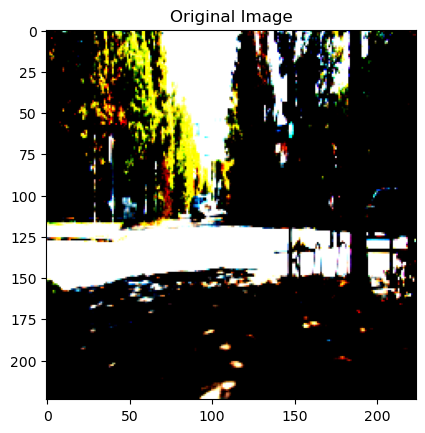

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


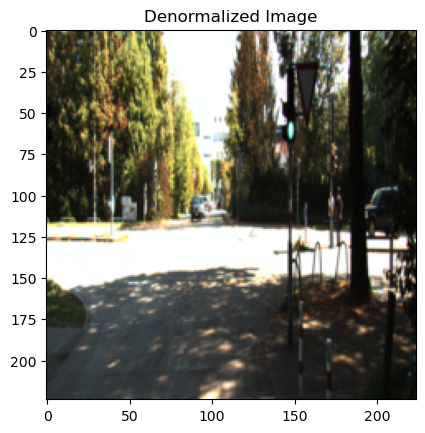

In [5]:
import matplotlib.pyplot as plt
import numpy as np

print(image.shape)
# Convert the tensor to a numpy array and then to an image
image_np = image.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

# Display the image
plt.imshow(image_np)
plt.title("Original Image")
plt.show()

# Denormalize the image
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np_denorm = std * image_np + mean

# Display the denormalized image
plt.imshow(image_np_denorm)
plt.title("Denormalized Image")
plt.show()

In [6]:
class PoseNet(nn.Module):
    """
    Pose estimation network to predict 6-DoF poses for source images relative to the target.

    Args:
        input_channels: Number of input channels (target image + source image stack).
    Returns:
        pose_final: Predicted 6-DoF poses for source images relative to the target.
                    Shape: [batch_size, num_source, 6]
    """
    def __init__(self, input_channels):
        super(PoseNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.pose_pred = nn.Conv2d(256, 6, kernel_size=1, stride=1)

        self.num_source = None  # Will be set based on input dimensions
        

    def forward(self, tgt_image, src_image_stack):
        # Concatenate target and source images along the channel axis
        inputs = torch.cat((tgt_image, src_image_stack), dim=1)
        # self.num_source = src_image_stack.shape[1] // (3 * tgt_image.shape[1])

        # Forward pass through convolutional layers
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        # Predict 6-DoF poses
        pose_pred = self.pose_pred(x)  # Shape: [batch_size, 6 * num_source, H, W]

        # Average spatial dimensions and reshape
        pose_avg = torch.mean(pose_pred, dim=(2, 3))  # Shape: [batch_size, 6 * num_source]
        print(pose_avg.shape)
        print(pose_avg)
        pose_final = 0.01 * pose_avg #.view(-1, self.num_source, 6)  # Shape: [batch_size, num_source, 6]

        return pose_final

In [7]:
posenet = PoseNet(6)

pose_final = posenet(sample['image_t']['processed_image'], sample['image_t1']['processed_image'])

print("Predicted 6-DoF poses:")
print(pose_final)

torch.Size([2, 6])
tensor([[ 0.0302,  0.0126, -0.0185, -0.0600, -0.0161, -0.0146],
        [ 0.0302,  0.0126, -0.0185, -0.0599, -0.0161, -0.0146]],
       grad_fn=<MeanBackward1>)
Predicted 6-DoF poses:
tensor([[ 0.0003,  0.0001, -0.0002, -0.0006, -0.0002, -0.0001],
        [ 0.0003,  0.0001, -0.0002, -0.0006, -0.0002, -0.0001]],
       grad_fn=<MulBackward0>)


In [8]:
print(sample.keys())
print(sample['image_t'].keys())
inputs = torch.cat((image, image_t1), dim=0)
print(inputs.shape)
conv1 = nn.Conv2d(6, 16, kernel_size=7, stride=2, padding=3)
out = conv1(inputs)


# self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
# self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
# self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
# self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
# self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
# self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
# self.pose_pred = nn.Conv2d(256, 6, kernel_size=1, stride=1)

# self.num_source = None  # Will be set based on input dimensions

dict_keys(['image_t', 'image_t1'])
dict_keys(['image_path', 'processed_image', 'feature_embedding'])
torch.Size([6, 224, 224])


In [9]:
#jiwoo
import torch.nn as nn
class DepthDecoder(nn.Module):
    def __init__(self, input_dim=384, output_size=(224, 224)):
        super(DepthDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(input_dim, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )
        self.upsample = nn.Upsample(size=output_size, mode="bilinear", align_corners=False)

    def forward(self, x):
        x = self.decoder(x)
        depth_map = self.upsample(x)
        depth_map.squeeze_(dim=1)
        return depth_map

In [10]:
decoder = DepthDecoder()
depth_map = decoder(sample['image_t']['feature_embedding'])
print(depth_map.shape)

torch.Size([2, 224, 224])


In [ ]:
# Example Parameters
B, H, W = 2, 224, 224  # Batch size, Height, Width
num_scales = 2         # Number of scales

# Correctly define depth_map with [B, 1, H, W] for each scale
depth_map = [torch.randn(B, 1, H // (2 ** s), W // (2 ** s)) for s in range(num_scales)]

# Verify shapes
#for s, depth in enumerate(depth_map):
#    print(f"depth_map[{s}] shape: {depth.shape}")  # Should be [2, 1, 224, 224] and [2, 1, 112, 112]

depth_map[0] shape: torch.Size([2, 1, 224, 224])
depth_map[1] shape: torch.Size([2, 1, 112, 112])


In [ ]:
from utils import compute_loss
image_t = sample['image_t']['processed_image']
image_t1 = sample['image_t1']['processed_image']
intrinsics_flat = [9.569475e+02, 0.000000e+00, 6.939767e+02,
                   0.000000e+00, 9.522352e+02, 2.386081e+02,
                   0.000000e+00, 0.000000e+00, 1.000000e+00]
pose_final = pose_final.unsqueeze(1)
#print(f"pose_final shape: {pose_final.shape}")  # Should be [B, 1, 6]
# Convert to a 3x3 matrix
B = image_t.shape[0]  # Example to get batch size
intrinsics_matrix = torch.tensor(intrinsics_flat).view(1, 3, 3).repeat(B, 1, 1)  # Shape: [B, 3, 3]
#print(f"intrinsics_matrix shape: {intrinsics_matrix.shape}")  # Should be [B, 3, 3]


compute_loss(pred_depth=depth_map, pred_poses=pose_final, tgt_image=image_t1, src_image_stack=image_t,intrinsics=intrinsics_matrix)


pose_final shape: torch.Size([2, 1, 6])
intrinsics_matrix shape: torch.Size([2, 3, 3])
Scale 0:
  curr_depth shape: torch.Size([2, 1, 224, 224])
  curr_tgt_image shape: torch.Size([2, 3, 224, 224])
  curr_src_image_stack shape: torch.Size([2, 3, 224, 224])
  Source 0: pose shape: torch.Size([2, 6])
Scale 1:
  curr_depth shape: torch.Size([2, 1, 112, 112])
  curr_tgt_image shape: torch.Size([2, 3, 112, 112])
  curr_src_image_stack shape: torch.Size([2, 3, 112, 112])
  Source 0: pose shape: torch.Size([2, 6])


(tensor(2.3618, grad_fn=<AddBackward0>),
 tensor(2.3242, grad_fn=<AddBackward0>),
 tensor(3.7569))

In [13]:
# Gpt generated!
class DepthDecoder(nn.Module):
    """
    Decoder for generating depth maps from encoded features.
    Args:
        encoder_channels: List of channel sizes from the encoder at each stage (e.g., [64, 128, 256, 512]).
    Returns:
        depth_map: Single-channel depth map of the input frame's spatial resolution.
    """
    def __init__(self, encoder_channels, output_channels=1):
        super(DepthDecoder, self).__init__()

        # Reverse the encoder channels to use skip connections
        self.encoder_channels = encoder_channels[::-1]
        
        # Create upsampling layers
        self.upconv1 = nn.ConvTranspose2d(self.encoder_channels[0], 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Combine skip connections with upsampled features
        self.conv1 = nn.Conv2d(self.encoder_channels[1] + 256, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.encoder_channels[2] + 128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.encoder_channels[3] + 64, 64, kernel_size=3, padding=1)

        # Final layer to produce depth map
        self.final_conv = nn.Conv2d(32, output_channels, kernel_size=3, padding=1)

    def forward(self, features):
        """
        Args:
            features: List of encoder features at each resolution (from deepest to shallowest).
                      The first element is the deepest layer's features.
        Returns:
            depth_map: Predicted single-channel depth map.
        """
        x = features[0]  # Start with the deepest feature map

        # First upsample
        x = self.upconv1(x)
        x = torch.cat((x, features[1]), dim=1)  # Add skip connection
        x = F.relu(self.conv1(x))

        # Second upsample
        x = self.upconv2(x)
        x = torch.cat((x, features[2]), dim=1)  # Add skip connection
        x = F.relu(self.conv2(x))

        # Third upsample
        x = self.upconv3(x)
        x = torch.cat((x, features[3]), dim=1)  # Add skip connection
        x = F.relu(self.conv3(x))

        # Final upsample
        x = self.upconv4(x)
        x = F.relu(x)

        # Final depth map
        depth_map = torch.sigmoid(self.final_conv(x))  # Use sigmoid for normalized depth map
        return depth_map